In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.decomposition import PCA

In [2]:
def load_sample_graph():
    num_nodes = 200
    avg_degree = 10
    rewiring_prob = 0.1
    G = nx.watts_strogatz_graph(num_nodes, avg_degree, rewiring_prob)
    
    return G

In [3]:
def plot_graph(G):
    pos = nx.spring_layout(G)  # Layout algorithm to position the nodes

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    # Show the plot
    plt.title("Graph")
    plt.axis('off')
    plt.show()

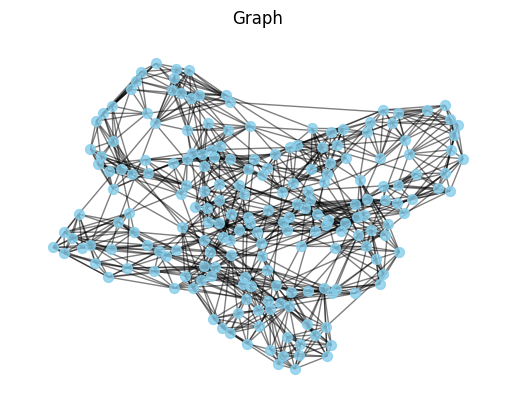

In [4]:
# Load the graph and plot it
graph = load_sample_graph()
plot_graph(graph)

In [5]:
def generate_random_walks(graph, num_walks, walk_length):
    walks = []
    nodes = list(graph.nodes())

    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = [node]
            while len(walk) < walk_length:
                neighbors = list(graph.neighbors(walk[-1]))
                if len(neighbors) > 0:
                    walk.append(random.choice(neighbors))
                else:
                    break
            walks.append(walk)

    return walks

In [6]:
def train_node2vec(walks, embedding_dim, num_epochs=10, window_size=5, learning_rate=0.025):
    # Initialize embeddings randomly
    embeddings = {node: np.random.rand(embedding_dim) for walk in walks for node in walk}

    for epoch in range(num_epochs):
        random.shuffle(walks)

        for walk in walks:
            for i, target_node in enumerate(walk):
                for context_node in walk[max(0, i - window_size): i] + walk[i + 1: i + window_size + 1]:
                    context_emb = embeddings[context_node]
                    loss_grad = 1 / (1 + np.exp(-context_emb.dot(embeddings[target_node])))
                    loss_grad = (1 - int(target_node == context_node) - loss_grad) * learning_rate
                    embeddings[target_node] += loss_grad * context_emb

    return embeddings

In [7]:
# Generate random walks
num_walks = 100
walk_length = 20
walks = generate_random_walks(graph, num_walks, walk_length)

In [8]:
# Train Node2Vec and get embeddings
embedding_dim = 128
embeddings = train_node2vec(walks, embedding_dim)

In [9]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(list(embeddings.values()))

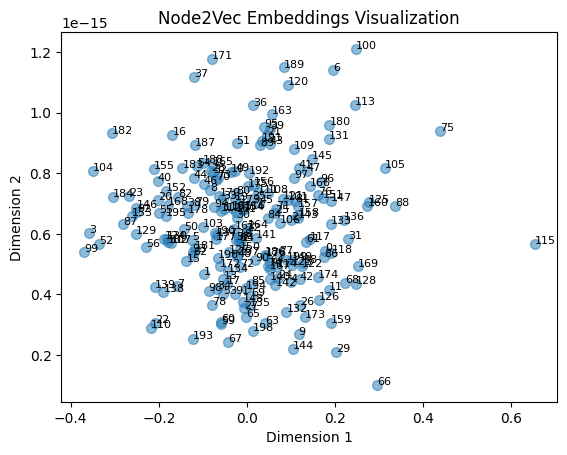

In [10]:
# Plot the nodes with their embeddings in 2D
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5, s=50)
for i, node in enumerate(list(embeddings.keys())):
    plt.annotate(node, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8)

plt.title("Node2Vec Embeddings Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [21]:
class Node2Vec:
    def __init__(self, graph, p=1, q=1, num_walks=10, walk_length=80, embedding_dim=128, num_epochs=50, window_size=5, learning_rate=0.025):
        self.graph = graph
        self.p = p
        self.q = q
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.embedding_dim = embedding_dim
        self.num_epochs = num_epochs
        self.window_size = window_size
        self.learning_rate = learning_rate

    def _node2vec_walk(self, start_node):
        walk = [start_node]

        while len(walk) < self.walk_length:
            current_node = walk[-1]
            neighbors = list(self.graph.neighbors(current_node))

            if len(neighbors) > 0:
                if len(walk) == 1:
                    walk.append(random.choice(neighbors))
                else:
                    prev_node = walk[-2]
                    next_node = self._choose_next_node(current_node, prev_node, neighbors)
                    walk.append(next_node)
            else:
                break

        return walk

    def _choose_next_node(self, current_node, prev_node, neighbors):
        weights = [self._get_weight(current_node, neighbor, prev_node) for neighbor in neighbors]
        return random.choices(neighbors, weights=weights)[0]

    def _get_weight(self, current_node, neighbor, prev_node):
        if neighbor == prev_node:
            return 1 / self.p
        elif neighbor in self.graph[current_node]:
            return 1
        else:
            return 1 / self.q

    def _generate_random_walks(self):
        walks = []
        nodes = list(self.graph.nodes())

        for _ in range(self.num_walks):
            random.shuffle(nodes)
            for node in nodes:
                walk = self._node2vec_walk(node)
                walks.append(walk)

        return walks

    def _train_node2vec(self, walks):
        embeddings = {node: np.random.rand(self.embedding_dim) for walk in walks for node in walk}

        for epoch in range(self.num_epochs):
            random.shuffle(walks)

            for walk in walks:
                for i, target_node in enumerate(walk):
                    for context_node in walk[max(0, i - self.window_size): i] + walk[i + 1: i + self.window_size + 1]:
                        context_emb = embeddings[context_node]
                        loss_grad = 1 / (1 + np.exp(-context_emb.dot(embeddings[target_node])))
                        loss_grad = (1 - int(target_node == context_node) - loss_grad) * self.learning_rate
                        embeddings[target_node] += loss_grad * context_emb

        return embeddings

    def fit(self):
        walks = self._generate_random_walks()
        embeddings = self._train_node2vec(walks)
        return embeddings

In [1]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

ModuleNotFoundError: No module named 'stellargraph'